# Example 1: Cepstral Analysis of solid amorphous Silica

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
from sys import path
path.append('/u/cm/lercole/software/scripts')
import thermocepstrum as tc
plt.rcParams['figure.figsize'] = (16, 9)
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

## 1. Load trajectory
Read the trajectory file, selecting the desired columns.

In [2]:
jfile = tc.io.LAMMPS_Current('Silica.dat', group_vectors=True)

# Solid Silica - BKS potential, melted and quenched
# 216 atoms, T~1000K, dens~2.295g/cm^3
# NVE, dt = 1.0 fs, 50 ns, output_step = 1.0 fs
# Temperature = 1065.705630 K, Volume = 3130.431110818 A^3
# LAMMPS metal units
c_flux1[1] c_flux1[2] c_flux1[3]
 #####################################
  all_ckeys =  {'flux1': array([0, 1, 2])}
 #####################################
Data length =  100001


In [3]:
jfile.read_currents(start_step=0, NSTEPS=0, select_ckeys=['flux1'])

  ckey =  {'flux1': array([0, 1, 2])}
    step =    100000 - 100.00% completed
  ( 100000 ) steps read.
DONE.  Elapsed time:  1.72919106483 seconds


{'flux1': array([[  91.472925,  630.61992 ,  199.16002 ],
        [  71.403952,  666.80601 ,  274.30247 ],
        [  47.754737,  678.10914 ,  305.95706 ],
        ..., 
        [ 466.489   , -360.14259 ,  -47.286976],
        [ 414.3014  , -378.42595 ,  166.42152 ],
        [ 331.99113 , -400.35311 ,  378.13009 ]])}

## 2. Heat Current object
Define a **HeatCurrent** from the trajectory, with the correct parameters.

In [4]:
DT_FS = 1.0                 # time step [fs]
TEMPERATURE = 1065.705630   # temperature [K]
VOLUME = 3130.431110818     # volume [A^3]

j = tc.current.HeatCurrent(jfile.data['flux1'], 'metal', DT_FS, TEMPERATURE, VOLUME)

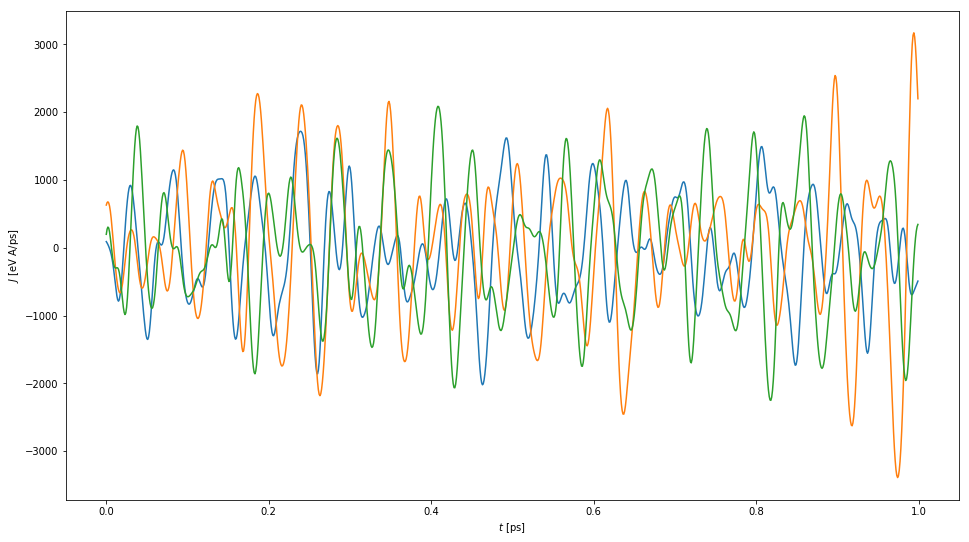

In [5]:
# trajectory
plt.plot(np.arange(1000)*j.DT_FS/1000., j.traj[:1000,:]);
plt.xlabel(r'$t$ [ps]')
plt.ylabel(r'$J$ [eV A/ps]');

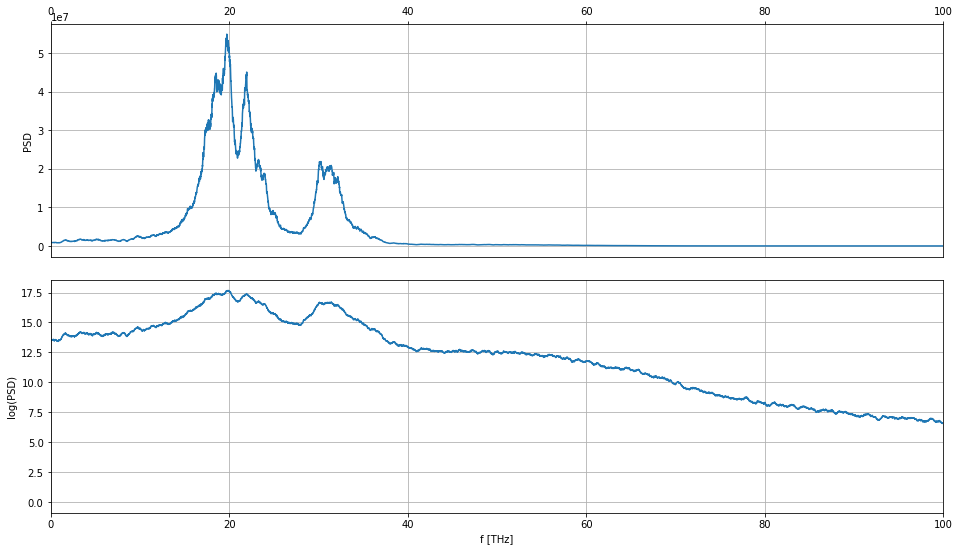

In [6]:
# Periodogram with give filtering window width
j.plot_periodogram(PSD_FILTER_W=0.5)
plt.xlim([0, 100]);

Original Nyquist freq  f_Ny =     500.00000 THz
Resampling freq          f* =      38.46154 THz
Sampling time         TSKIP =            13 steps
                            =     13.000000 fs
PSD      @cutoff  (pre-filter) = 782295.28944
                 (post-filter) = 651806.17556
log(PSD) @cutoff  (pre-filter) =     13.38644
                 (post-filter) =     13.19383
% of original PSD Power f<f* (pre-filter)  = 98.072054
min(PSD)      (pre-filter)  =      0.97609
min(PSD)     (post-filter)  =   4541.87180


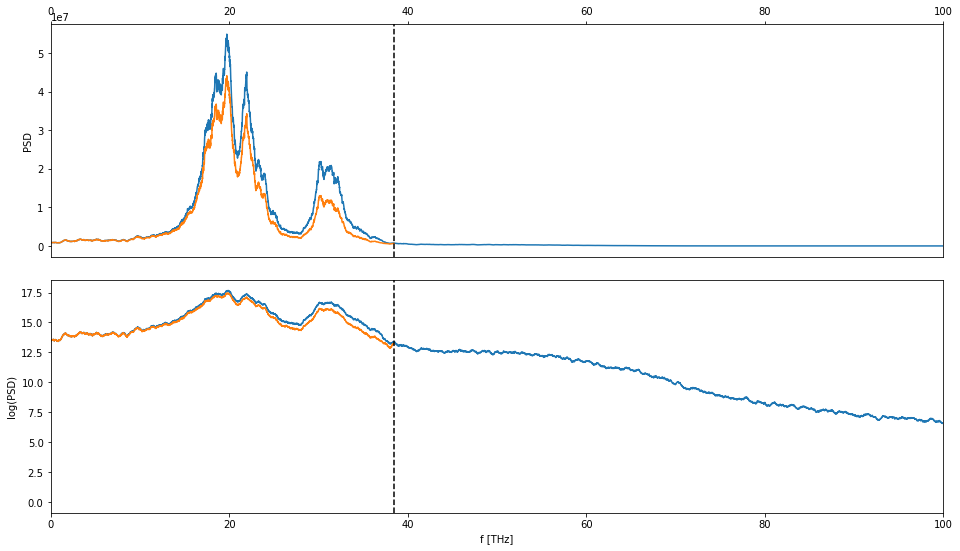

In [7]:
jf, ax = tc.current.simulate_fstar(j, fstar_THz=40.0, plot=True)
plt.xlim([0, 100]);

## 2. Compute PSD
Compute Power Spectral Density and filter it for visualization.

In [11]:
FILTER_WINDOW_WIDTH = 0.0005  # filter window width [reduced frequency units]
j.compute_psd(FILTER_WINDOW_WIDTH, average_components=True)

In [12]:
print 'There are {:d} frequencies.'.format(j.Nfreqs)
print 'Nyquist frequency = {:f} THz'.format(j.Nyquist_f_THz)
print 'freqs = ', j.freqs_THz, 'THz'

There are 50001 frequencies.
Nyquist frequency = 500.000000 THz
freqs =  [  0.00000000e+00   1.00000000e-02   2.00000000e-02 ...,   4.99980000e+02
   4.99990000e+02   5.00000000e+02] THz


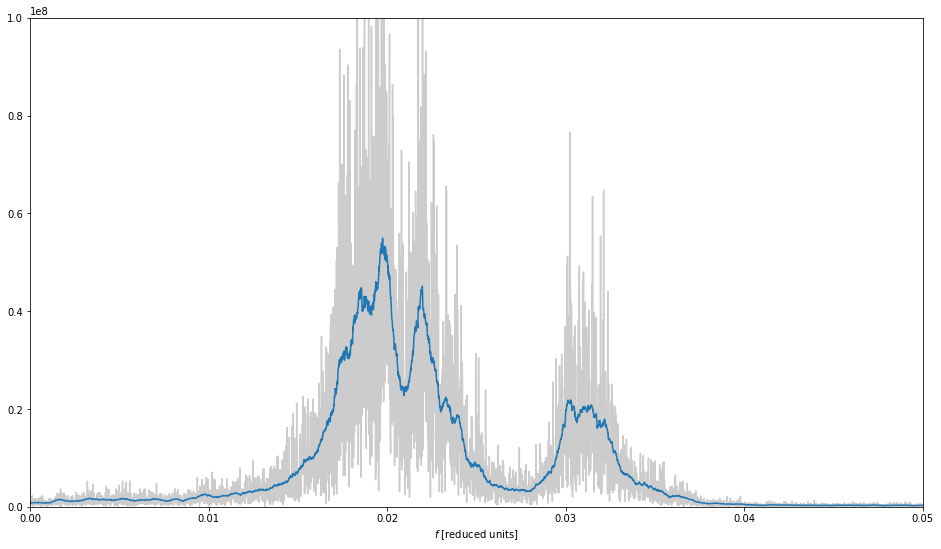

In [13]:
# PSD (in reduced units)
plt.plot(j.freqs, j.psd, '0.8')
plt.plot(j.freqs, j.fpsd, c=c[0])
plt.xlim([0., 0.05])
plt.ylim([0., 1e8])
plt.xlabel(r'$f$ [reduced units]');

## 3. Resample and compute PSD
Choose a cutoff frequency $f^*$ from previous graph. Resample trajectory and recompute PSD.

In [14]:
TSKIP = int(round(0.5/0.028))
jf = tc.md.MDSample(traj = tc.md.tools.filter_and_sample(j.traj, TSKIP, TSKIP), DT_FS=TSKIP*DT_FS)
print 'Sampling time = {:6d} steps\n              = {:6.2f} fs'.format(TSKIP, TSKIP*DT_FS)

Sampling time =     18 steps
              =  18.00 fs


In [15]:
FILTER_WINDOW_WIDTH = 0.0005*TSKIP  # filter window width [reduced frequency units]
jf.compute_psd(FILTER_WINDOW_WIDTH, average_components=True, DT=TSKIP)  # DT is used to normalize the new PSD

TypeError: compute_psd() got an unexpected keyword argument 'DT'

In [ ]:
print 'There are {:d} frequencies.'.format(jf.Nfreqs)
print 'Nyquist frequency = {:f} THz'.format(jf.Nyquist_f_THz)
print 'freqs = ', jf.freqs_THz, 'THz'

In [ ]:
# PSD of resampled series (in THz)
plt.plot(j.freqs_THz, j.psd,    '0.8')
plt.plot(jf.freqs_THz, jf.psd,  c=c[1], alpha=0.2 )
plt.plot(j.freqs_THz,  j.fpsd,  c=c[0], label='original')
plt.plot(jf.freqs_THz, jf.fpsd, c=c[1], label='resampled')
plt.axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
plt.ylim([0., 1e8])
plt.xlabel(r'$f$ [THz]')
plt.legend();

In [ ]:
# log-PSD
plt.plot(j.freqs_THz, j.logpsd,    '0.8')
plt.plot(jf.freqs_THz, jf.logpsd,  c=c[1], alpha=0.2)
plt.plot(j.freqs_THz,  j.flogpsd,  c=c[0], label='original')
plt.plot(jf.freqs_THz, jf.flogpsd, c=c[1], label='resampled')
plt.axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
plt.ylim([11., 19.])
plt.xlabel(r'$f$ [THz]')
plt.legend();

## 4. Cepstral Analysis
- compute theoretical distribution parameters for Cepstral Analysis.

In [ ]:
ck_THEORY_var, psd_THEORY_mean = tc.md.cepstral.multicomp_cepstral_parameters(jf.Nfreqs, jf.N_COMPONENTS)

- compute Cepstral coefficients and AIC

In [ ]:
jf.dct = tc.md.CosFilter(jf.logpsd, ck_theory_var=ck_THEORY_var, psd_theory_mean=psd_THEORY_mean, \
                         aic_type='aic', Kmin_corrfactor=1.0)

In [ ]:
jf.dct.logpsdK

In [ ]:
# Cepstral Coefficients
plt.plot(jf.dct.logpsdK, 'o-', c=c[0])
plt.plot(jf.dct.logpsdK + jf.dct.logpsdK_THEORY_std, '--', c=c[0])
plt.plot(jf.dct.logpsdK - jf.dct.logpsdK_THEORY_std, '--', c=c[0])
plt.xlim([0, 50])
plt.ylim([-0.5, 0.5]);
plt.grid();

In [ ]:
# AIC
plt.plot(jf.dct.aic, '.-', c=c[0])
plt.xlim([0,200])
plt.ylim([2800, 3000]);

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

- compute $L_0$ (tau) as a function of the cutoff

In [ ]:
jf.dct.scan_filter_tau()

In [ ]:
# L_0 as a function of cutoff K
plt.plot(jf.dct.logtau, '.-', c=c[0])
plt.plot(jf.dct.logtau + jf.dct.logtau_THEORY_std, '--', c=c[0])
plt.plot(jf.dct.logtau - jf.dct.logtau_THEORY_std, '--', c=c[0])
plt.xlim([0,200])
plt.ylim([12.5, 14.5]);
plt.axvline(x=jf.dct.aic_Kmin, ls='--', c='r')

print 'K of AIC_min = {:d}'.format(jf.dct.aic_Kmin)
print 'AIC_min = {:f}'.format(jf.dct.aic_min)

- collect the results :)

In [ ]:
print 'L_0* = {:15f} +/- {:10f}'.format(jf.dct.logtau_Kmin, jf.dct.logtau_std_Kmin)
print 'S_0* = {:15f} +/- {:10f}'.format(jf.dct.tau_Kmin, jf.dct.tau_std_Kmin)

In [ ]:
kappa_Kmin = jf.dct.tau_Kmin * kappa_scale * 0.5
kappa_std_Kmin = jf.dct.tau_std_Kmin * kappa_scale * 0.5
print 'kappa* = {:15f} +/- {:10f}  W/mK'.format(kappa_Kmin, kappa_std_Kmin)

- you can also visualize the filtered PSD...

In [ ]:
# filtered log-PSD
plt.plot(j.freqs_THz, j.logpsd,    '0.8')
plt.plot(jf.freqs_THz, jf.logpsd,  c=c[1], alpha=0.2)
plt.plot(j.freqs_THz,  j.flogpsd,  c=c[0], label='original')
plt.plot(jf.freqs_THz, jf.flogpsd, c=c[1], label='resampled')
plt.plot(jf.freqs_THz, jf.dct.logpsd, c=c[2], lw=2, label='filtered')
plt.axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0., 50.])
plt.ylim([11., 19.])
plt.xlabel(r'$f$ [THz]')
plt.legend();